In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, log_loss
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torchvision
from torch.optim import Adam
import torchvision
from torchvision.transforms import v2

import warnings
import time

seed = 1001
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)
warnings.simplefilter('ignore', UserWarning)

In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, log_loss
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torchvision
from torch.optim import Adam
import torchvision
from torchvision.transforms import v2

import warnings
import time

seed = 1001
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)
warnings.simplefilter('ignore', UserWarning)

In [3]:
# !pip install torchquantum

In [4]:
import torchquantum as tq
from torchquantum.measurement import expval_joint_analytical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(torch.cuda.device_count())
print([torch.cuda.get_device_name('cuda:'+str(i)) for i in range(torch.cuda.device_count())])

1
['NVIDIA GeForce RTX 4090']


In [5]:
data = torchvision.datasets.MNIST(root='./data', train=True, download=True)
data_tr, label_tr = data.train_data, data.train_labels
data = torchvision.datasets.MNIST(root='./data', train=False, download=True)
data_te, label_te = data.test_data, data.test_labels
print(data_tr.shape, data_te.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


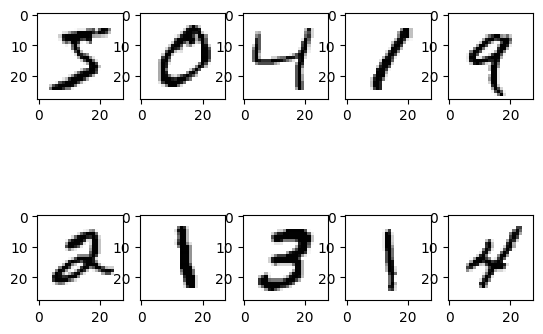

In [6]:
num = 10
for i in range(num):
    ax = plt.subplot(2,num//2,i+1)
    ax.imshow(data_tr[i].detach().numpy(), cmap='gray_r')

In [7]:
dataset_name = 'mnist'
n_qubits = 7 # data_tr.shape[1]
n_class = len(np.unique(label_tr))

In [8]:
class CoeffLayer(nn.Module):
    def __init__(self, coeff):
        super().__init__()
        self.coeff = torch.nn.Parameter(coeff)
    def forward(self, x):
        ret = x * self.coeff
        return ret

class ConstCoeffLayer(nn.Module):
    def __init__(self, coeff):
        super().__init__()
        self.coeff = coeff
    def forward(self, x):
        ret = x * self.coeff
        return ret

In [9]:
# 28x28 => 16x7x7 
class QNNsubModel(nn.Module):
    def __init__(self):
        # params is numpy array
        super().__init__()
        self.n_wires=7
        self.encoder_gates = ([tq.functional.rx] * self.n_wires + [tq.functional.ry] * self.n_wires)*3+[tq.functional.rx] * self.n_wires
        self.n_block = 4
        self.n_depth_per_block = 20
        params = np.random.rand( self.n_wires*2*self.n_block*self.n_depth_per_block)*math.pi
        self.u_layers = tq.QuantumModuleList()
        for j in range(self.n_block*self.n_depth_per_block):
            for i in range(self.n_wires):
                self.u_layers.append( tq.RX(has_params=True, trainable=True, init_params=params[i+(2*j)*self.n_wires]) )
            for i in range(self.n_wires):
                self.u_layers.append( tq.RY(has_params=True, trainable=True, init_params=params[i+(2*j+1)*self.n_wires]) )

    def forward(self, x):
        bsz = x.shape[0]
        qdev = tq.QuantumDevice(
            n_wires=self.n_wires, bsz = bsz, device=x.device, record_op=False
        )
        ###
        n_depth_per_block = self.n_depth_per_block
        for nb in range(0,3):
            for k in range(n_depth_per_block):
                for j in range(2*nb*n_depth_per_block+2*k,2*nb*n_depth_per_block+2*k+2):
                    for i in range(self.n_wires):
                        self.u_layers[i+j*self.n_wires](qdev, wires=i)
                for i in range(self.n_wires):
                    qdev.cz(wires=[i,(i+1)%self.n_wires])
            # data encoding
            for j in range(2*nb,2*nb+2):
                for k in range(self.n_wires):
                    self.encoder_gates[k+j*self.n_wires](qdev, wires=k, params=x[:, k+j*self.n_wires])
            for i in range(self.n_wires):
                qdev.cz(wires=[i,(i+1)%self.n_wires])
        for nb in range(3,self.n_block-1):
            for k in range(n_depth_per_block):
                for j in range(2*nb*n_depth_per_block+2*k,2*nb*n_depth_per_block+2*k+2):
                    for i in range(self.n_wires):
                        self.u_layers[i+j*self.n_wires](qdev, wires=i)
                for i in range(self.n_wires):
                    qdev.cz(wires=[i,(i+1)%self.n_wires])
            # data encoding
            for j in range(2*nb,2*nb+1):
                for k in range(self.n_wires):
                    self.encoder_gates[k+j*self.n_wires](qdev, wires=k, params=x[:, k+j*self.n_wires])
            for i in range(self.n_wires):
                qdev.cz(wires=[i,(i+1)%self.n_wires])
        for nb in range(self.n_block-1,self.n_block):
            for k in range(n_depth_per_block):
                for j in range(2*nb*n_depth_per_block+2*k,2*nb*n_depth_per_block+2*k+2):
                    for i in range(self.n_wires):
                        self.u_layers[i+j*self.n_wires](qdev, wires=i)
                if nb==self.n_block-1 and k==n_depth_per_block-1:
                    break
                for i in range(self.n_wires):
                    qdev.cz(wires=[i,(i+1)%self.n_wires])

        obs_list = [ expval_joint_analytical(qdev, "I"*(i)+Pauli+"I"*(self.n_wires-1-i)) for Pauli in ["X","Z"] for i in range(5)]
        # obs_list = [ expval_joint_analytical(qdev, "I"*(i)+Pauli+"I"*(self.n_wires-1-i)) for Pauli in ["X"] for i in range(10)]
        ret = torch.stack(obs_list, dim=1)
        return ret


In [10]:
'''
class QNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn0, self.qnn1, self.qnn2, self.qnn3 = QNNsubModel(), QNNsubModel(), QNNsubModel(), QNNsubModel()
        self.qnn4, self.qnn5, self.qnn6, self.qnn7 = QNNsubModel(), QNNsubModel(), QNNsubModel(), QNNsubModel()
    def forward(self, x):
        LEN = 98
        in_x = [ x[:,i*LEN:(i+1)*LEN] for i in range(8) ]
        ret0, ret1, ret2, ret3 = self.qnn0(in_x[0]), self.qnn1(in_x[1]), self.qnn2(in_x[2]), self.qnn3(in_x[3])
        ret4, ret5, ret6, ret7 = self.qnn4(in_x[4]), self.qnn5(in_x[5]), self.qnn6(in_x[6]), self.qnn7(in_x[7])
        ret = ret0 + ret1 + ret2 + ret3 
        ret = ret4 + ret5 + ret6 + ret7
        return ret
'''

'\nclass QNNModel(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.qnn0, self.qnn1, self.qnn2, self.qnn3 = QNNsubModel(), QNNsubModel(), QNNsubModel(), QNNsubModel()\n        self.qnn4, self.qnn5, self.qnn6, self.qnn7 = QNNsubModel(), QNNsubModel(), QNNsubModel(), QNNsubModel()\n    def forward(self, x):\n        LEN = 98\n        in_x = [ x[:,i*LEN:(i+1)*LEN] for i in range(8) ]\n        ret0, ret1, ret2, ret3 = self.qnn0(in_x[0]), self.qnn1(in_x[1]), self.qnn2(in_x[2]), self.qnn3(in_x[3])\n        ret4, ret5, ret6, ret7 = self.qnn4(in_x[4]), self.qnn5(in_x[5]), self.qnn6(in_x[6]), self.qnn7(in_x[7])\n        ret = ret0 + ret1 + ret2 + ret3 \n        ret = ret4 + ret5 + ret6 + ret7\n        return ret\n'

In [11]:
class QNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn0, self.qnn1, self.qnn2, self.qnn3 = QNNsubModel(), QNNsubModel(), QNNsubModel(), QNNsubModel()
        self.qnn4, self.qnn5, self.qnn6, self.qnn7 = QNNsubModel(), QNNsubModel(), QNNsubModel(), QNNsubModel()
        self.qnn8, self.qnn9, self.qnn10, self.qnn11 = QNNsubModel(), QNNsubModel(), QNNsubModel(), QNNsubModel()
        self.qnn12, self.qnn13, self.qnn14, self.qnn15 = QNNsubModel(), QNNsubModel(), QNNsubModel(), QNNsubModel()
    def forward(self, x):
        LEN = 49
        in_x = [ x[:,i*LEN:(i+1)*LEN] for i in range(16) ]
        ret0, ret1, ret2, ret3 = self.qnn0(in_x[0]), self.qnn1(in_x[1]), self.qnn2(in_x[2]), self.qnn3(in_x[3])
        ret4, ret5, ret6, ret7 = self.qnn4(in_x[4]), self.qnn5(in_x[5]), self.qnn6(in_x[6]), self.qnn7(in_x[7])
        ret8, ret9, ret10, ret11 = self.qnn8(in_x[8]), self.qnn9(in_x[9]), self.qnn10(in_x[10]), self.qnn11(in_x[11])
        ret12, ret13, ret14, ret15 = self.qnn12(in_x[12]), self.qnn13(in_x[13]), self.qnn14(in_x[14]), self.qnn15(in_x[15])
        ret = ret0 + ret1 + ret2 + ret3 \
            + ret4 + ret5 + ret6 + ret7 \
            + ret8 + ret9 + ret10 + ret11 \
            + ret12 + ret13 + ret14 + ret15
        return ret

In [12]:
def train(data, label, model, optimizer):
    optimizer.zero_grad()
    pred = model(data)
    loss = torch.nn.CrossEntropyLoss()(pred, label)
    loss.backward()
    optimizer.step()
    acc = (pred.argmax(axis=1) == label).sum().item() / len(label)
    # acc = accuracy_score(y_tr, pred.argmax(axis=1).cpu().detach().numpy() )
    print(f"train loss: {loss.item():.5f} train acc: {acc:.3f}", end='\n')
    return loss.item(), acc

def valid(data, label, model):
    with torch.no_grad():
        pred = model(data)
        loss = torch.nn.CrossEntropyLoss()(pred, label)
    acc = (pred.argmax(axis=1) == label).sum().item() / len(label)
    # acc = accuracy_score(y_te, pred.argmax(axis=1).cpu().detach().numpy() )
    print(f"valid loss: {loss.item():.5f} valid acc: {acc:.3f}", end='\n')
    return loss.item(), acc

In [13]:
data_tr = data_tr.reshape(-1,data_tr.shape[1]*data_tr.shape[2]).detach().numpy()
data_te = data_te.reshape(-1,data_te.shape[1]*data_te.shape[2]).detach().numpy()
data_tr = data_tr/255*math.pi/4
data_te = data_te/255*math.pi/4

data_tr = torch.from_numpy(data_tr)
data_te = torch.from_numpy(data_te)

In [14]:
all_all_fsteps = []
all_all_bsteps = []
all_all_vsteps = []

max_epochs = 100
lr = 0.005 # 5e-3

data_te, label_te = data_te.to(device), label_te.to(device)
model = torch.nn.Sequential(
    QNNModel(),
    ConstCoeffLayer(2),
    nn.Softmax(dim=1)
)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=5e-5)
all_tr_loss = []
all_tr_acc = []

all_fsteps = []
all_bsteps = []
for i_epoch in range(max_epochs):
    tmp_skf = StratifiedKFold(n_splits=50) # for minibatch training
    # 60000/100 = 600, min/epoch
    for i_fold, (_, tmp_te) in enumerate(tmp_skf.split(data_tr, label_tr)):
        print(f"{i_epoch}th epoch-{i_fold}th iteration:", end=" ")
        loss_tr, acc_tr = train(data_tr[tmp_te].to(device), label_tr[tmp_te].to(device), model, optimizer)
    all_tr_loss.append(loss_tr)
    all_tr_acc.append(acc_tr)
    loss_valid, acc_valid = valid(data_te, label_te, model)
    ###

0th epoch-0th iteration: train loss: 2.30444 train acc: 0.106
0th epoch-1th iteration: train loss: 2.23444 train acc: 0.207
0th epoch-2th iteration: train loss: 2.17510 train acc: 0.314
0th epoch-3th iteration: train loss: 2.12793 train acc: 0.347
0th epoch-4th iteration: train loss: 2.06536 train acc: 0.456
0th epoch-5th iteration: train loss: 2.05099 train acc: 0.502
0th epoch-6th iteration: train loss: 2.03136 train acc: 0.531
0th epoch-7th iteration: train loss: 1.98031 train acc: 0.605
0th epoch-8th iteration: train loss: 1.91370 train acc: 0.667
0th epoch-9th iteration: train loss: 1.89083 train acc: 0.703
0th epoch-10th iteration: train loss: 1.89871 train acc: 0.695
0th epoch-11th iteration: train loss: 1.88061 train acc: 0.706
0th epoch-12th iteration: train loss: 1.86146 train acc: 0.715
0th epoch-13th iteration: train loss: 1.83066 train acc: 0.731
0th epoch-14th iteration: train loss: 1.84340 train acc: 0.716
0th epoch-15th iteration: train loss: 1.78153 train acc: 0.790
0t

In [15]:
print(f"train acc: {acc_tr}, test acc: {acc_valid}, train loss: {loss_tr}, valid loss: {loss_valid}")

train acc: 0.9683333333333334, test acc: 0.9467, train loss: 1.5291386842727661, valid loss: 1.5513449907302856


In [16]:
'''
n_depth_per_block = model[0].n_depth_per_block
coeff = model[1].coeff
prefix_name = dataset_name+"_"+"qnn"+str(n_depth_per_block)+"_c"+str(coeff)+"_"+str(n_qubits)+"qubits_"
if True:
    pd.DataFrame(all_tr_acc).to_csv(dataset_name+"_"+str(n_depth_per_block)+"_qnn_c35_"+str(n_qubits)+"qubits_tr_acc.csv", index=False)
    pd.DataFrame(all_valid_acc).to_csv(dataset_name+"_"+str(n_depth_per_block)+"_qnn_c35_"+str(n_qubits)+"qubits_valid_acc.csv", index=False)
    pd.DataFrame(all_tr_loss).to_csv(dataset_name+"_"+str(n_depth_per_block)+"_qnn_c35_"+str(n_qubits)+"qubits_tr_loss.csv", index=False)
    pd.DataFrame(all_valid_loss).to_csv(dataset_name+"_"+str(n_depth_per_block)+"_qnn_35_"+str(n_qubits)+"qubits_valid_loss.csv", index=False)
'''

'\nn_depth_per_block = model[0].n_depth_per_block\ncoeff = model[1].coeff\nprefix_name = dataset_name+"_"+"qnn"+str(n_depth_per_block)+"_c"+str(coeff)+"_"+str(n_qubits)+"qubits_"\nif True:\n    pd.DataFrame(all_tr_acc).to_csv(dataset_name+"_"+str(n_depth_per_block)+"_qnn_c35_"+str(n_qubits)+"qubits_tr_acc.csv", index=False)\n    pd.DataFrame(all_valid_acc).to_csv(dataset_name+"_"+str(n_depth_per_block)+"_qnn_c35_"+str(n_qubits)+"qubits_valid_acc.csv", index=False)\n    pd.DataFrame(all_tr_loss).to_csv(dataset_name+"_"+str(n_depth_per_block)+"_qnn_c35_"+str(n_qubits)+"qubits_tr_loss.csv", index=False)\n    pd.DataFrame(all_valid_loss).to_csv(dataset_name+"_"+str(n_depth_per_block)+"_qnn_35_"+str(n_qubits)+"qubits_valid_loss.csv", index=False)\n'

In [17]:
'''
lr0.005 d20 c5

'''

'\nlr0.005 d20 c5\n\n'